### Imports, configurations et fonction aides

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import Warnings
import warnings
warnings.simplefilter(action="ignore")

from sklearn.preprocessing import RobustScaler

# Setting Configurations:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

## 1. Analyse exploratoire des données

### Voir les 5 premières données

In [4]:
df = pd.read_csv("./diabetes.csv")
df. head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


### Voir le nombre de rangées et colonnes

In [5]:
df.shape

(768, 9)

### Analyse de la variable cible (n de personnes sans et avec diabetes)

In [6]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

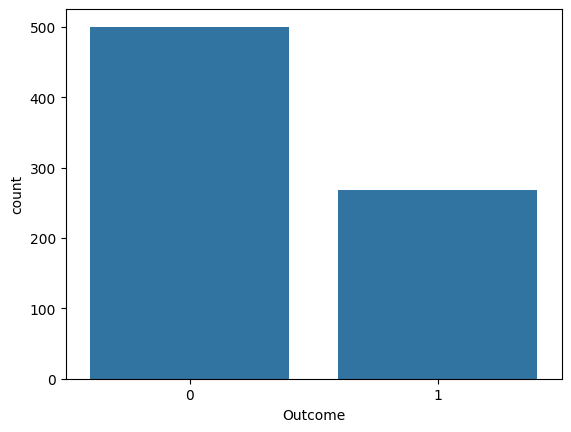

In [7]:
sns.countplot(x="Outcome", data=df)     # We can see the class information of the dependent variable in columns.
plt.show()

In [8]:
# en pourcentage
100 * df["Outcome"].value_counts() / len(df)

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

### Analyse des features

In [9]:
df.describe().T     # Describe simply fetches numeric variables and summarizes their status.

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


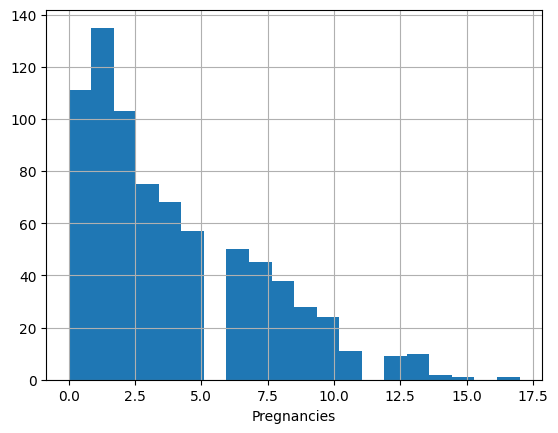

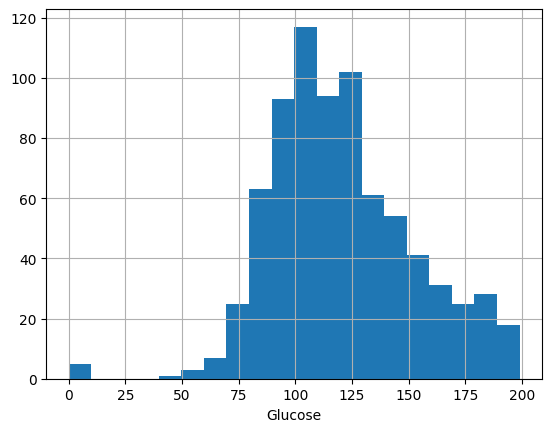

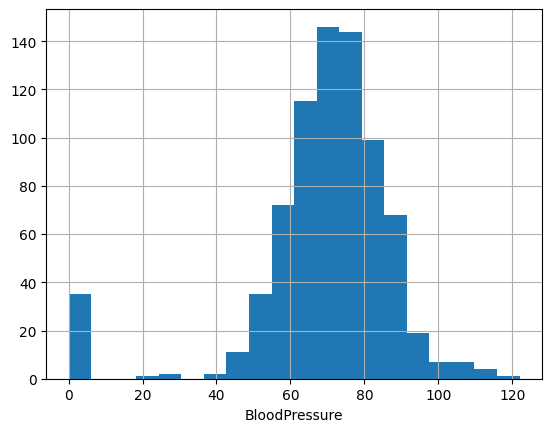

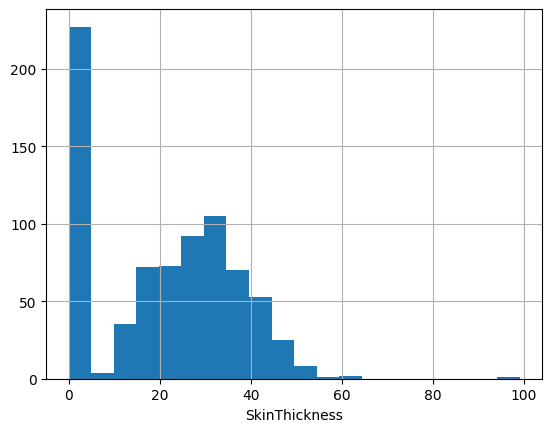

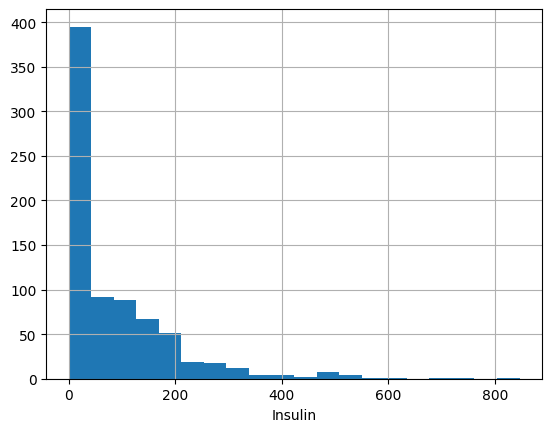

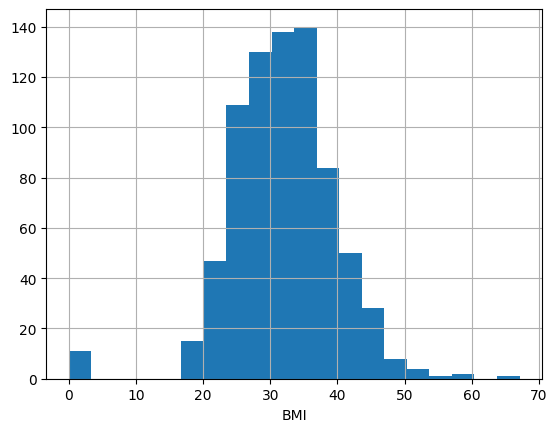

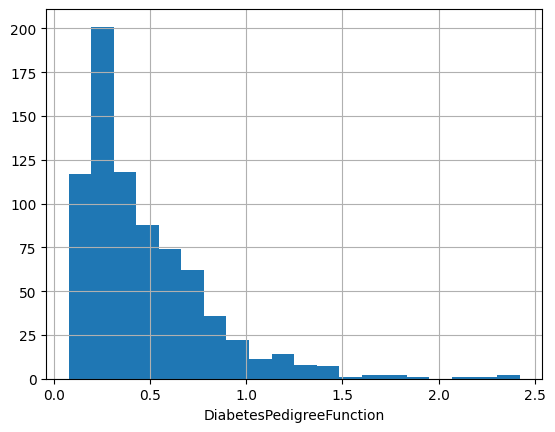

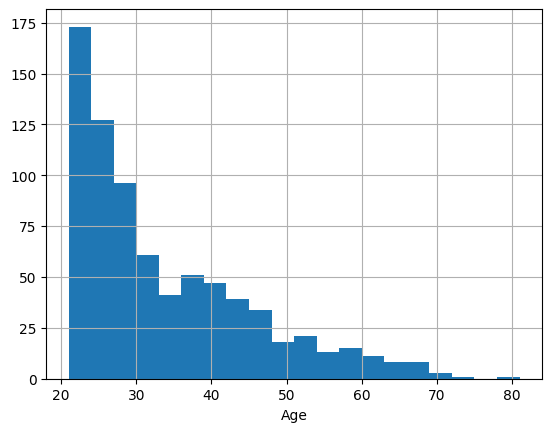

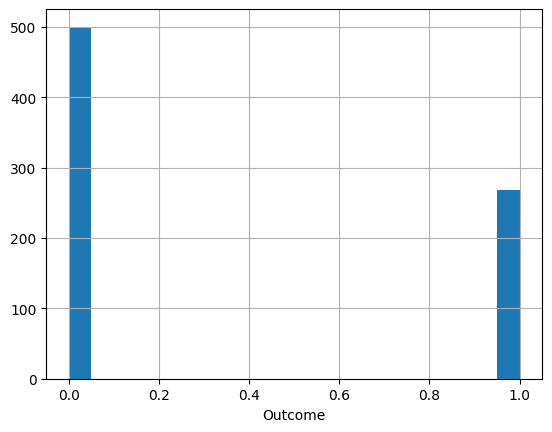

In [10]:
# Plots pour les features
def plot_numerical_col(dataframe, numerical_col):           # we define a function to show numeric columns.
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)    # The reason we entered the block=true argument; We don't want the graphics that will show one after the other to overwhelm each other.

for col in df.columns:
    plot_numerical_col(df, col)

### Cible vs Features

In [11]:
cols = [col for col in df.columns if "Outcome" not in col]
df.groupby("Outcome").agg({"Pregnancies": "mean"})

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




## 2. Preprocessing des données

### Voir si les données contient des valeurs null

In [12]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [13]:
for col in cols:
    print(col, check_outlier(df, col))

replace_with_thresholds(df, "Insulin")

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

df.head()

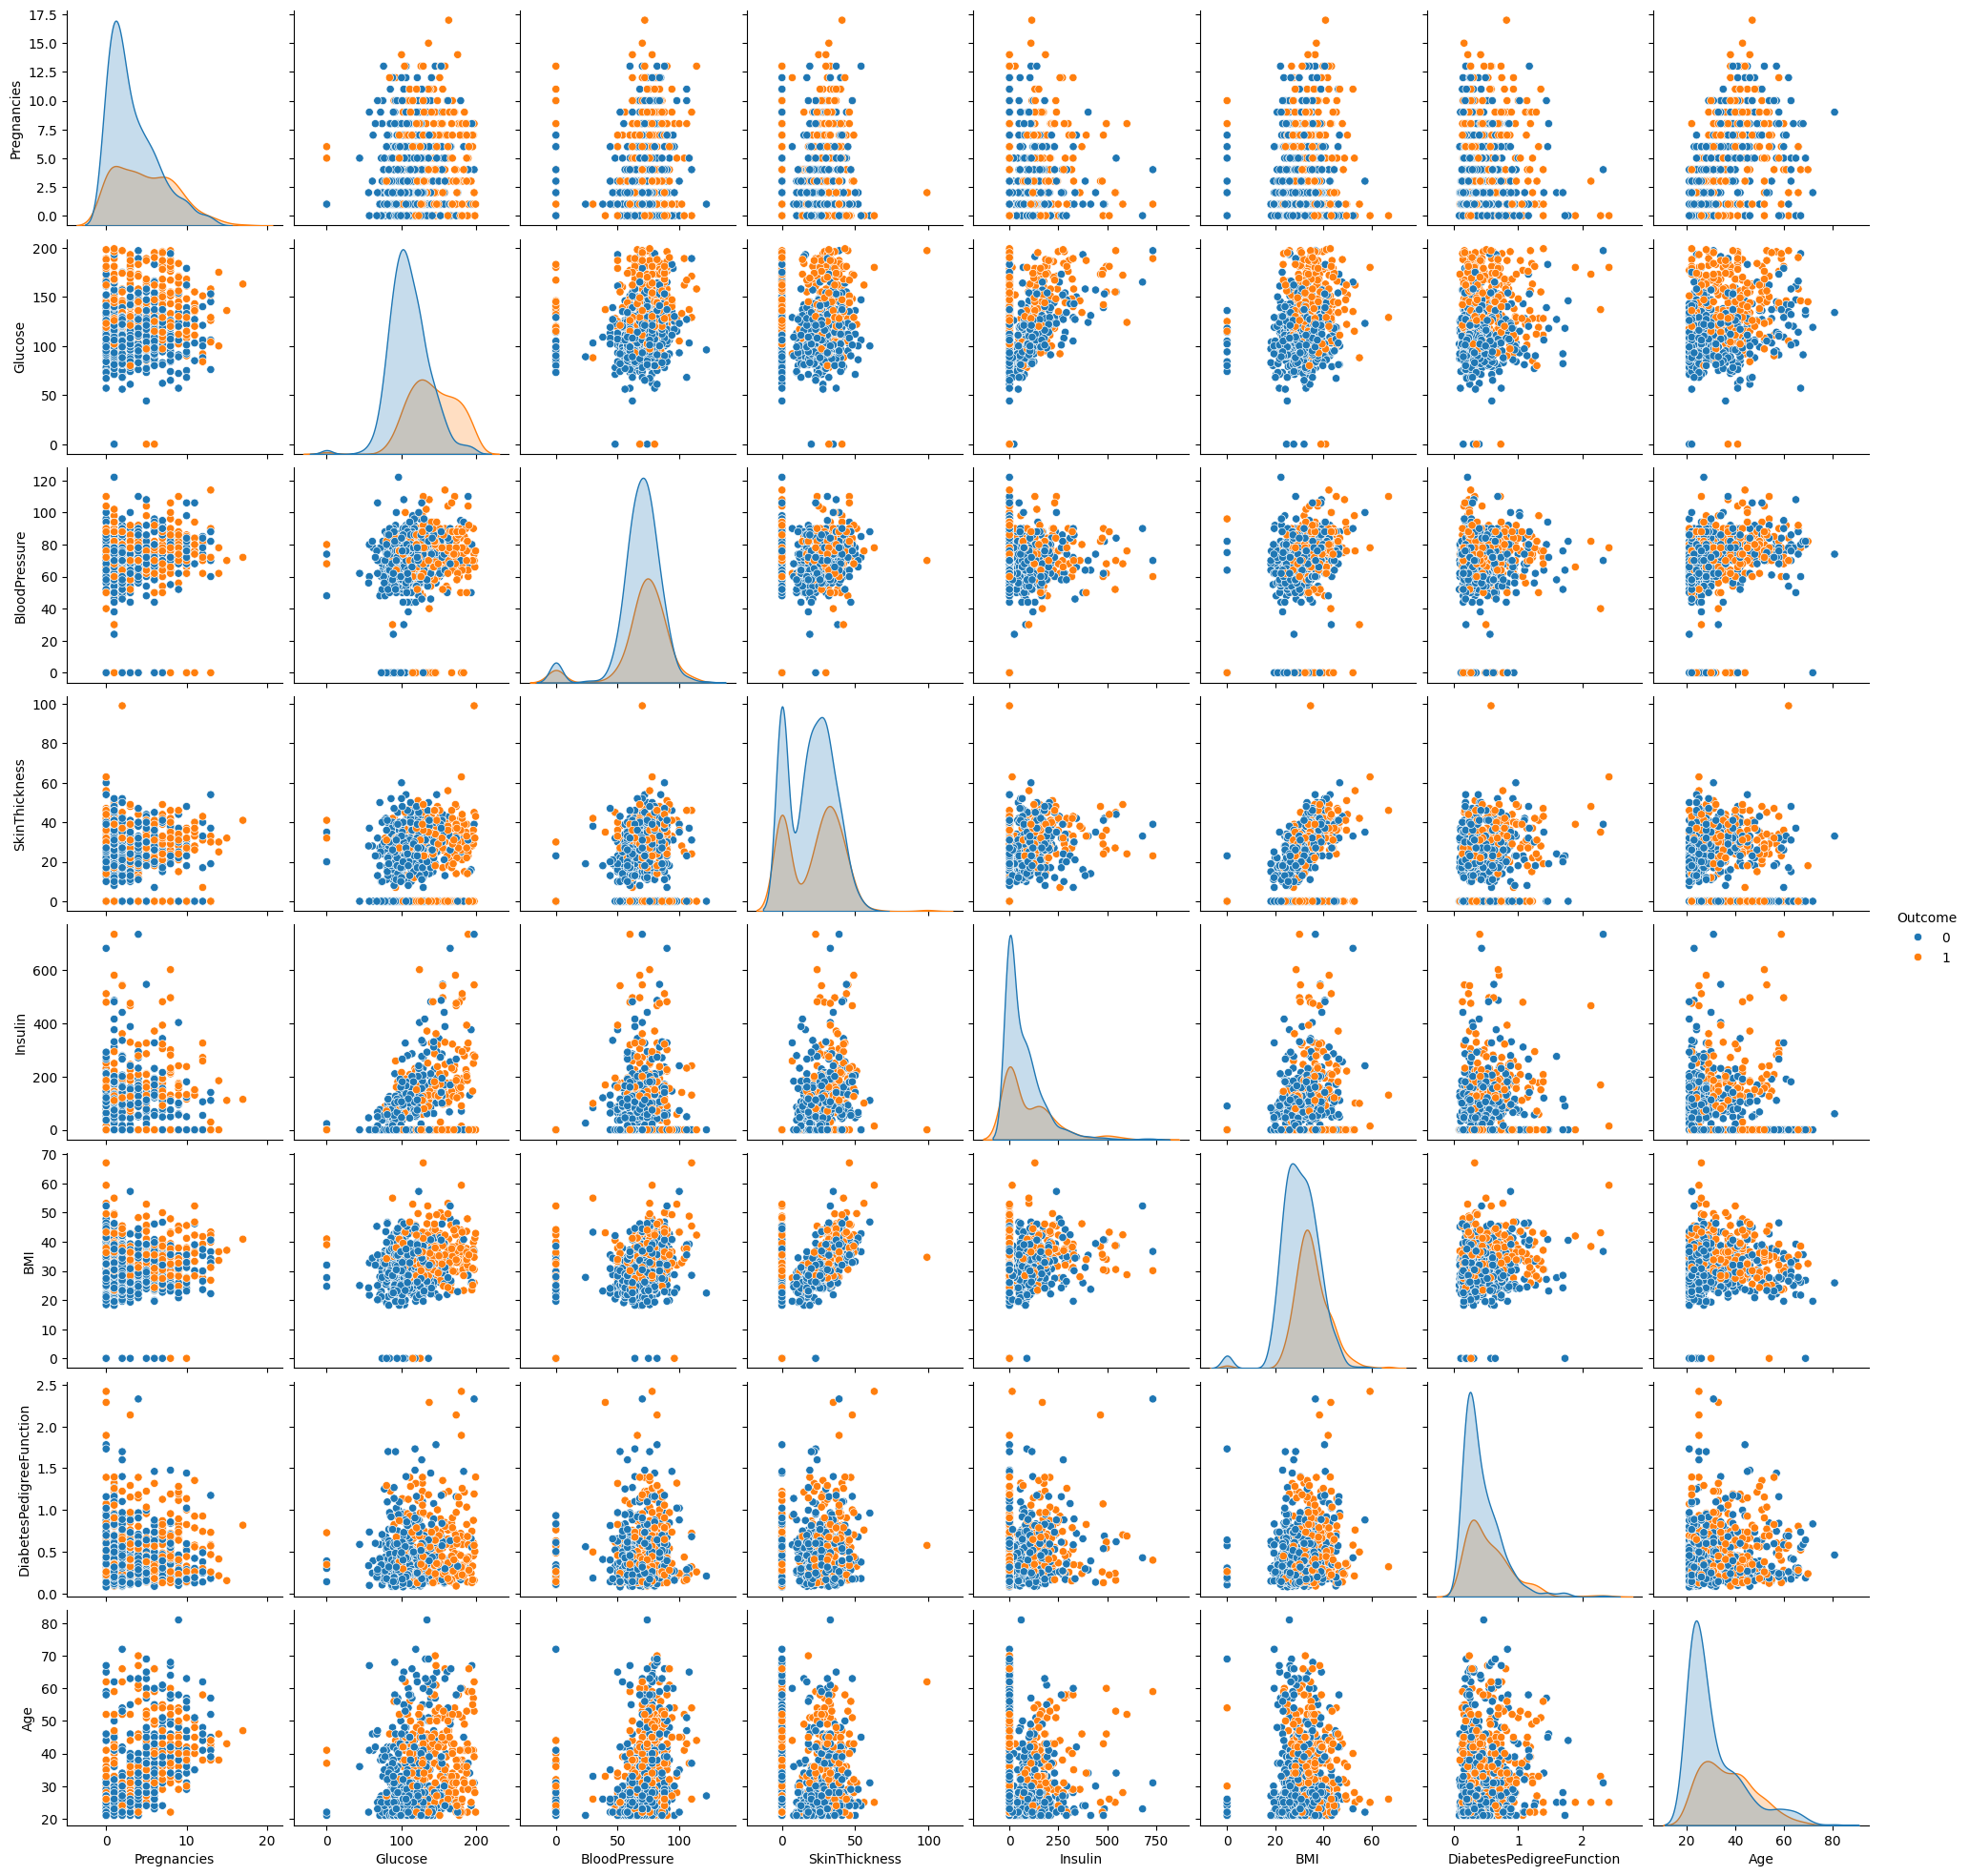

In [14]:
sns.pairplot(df, hue="Outcome")
plt.show()

## 3. Model et Prédiction

In [15]:
import numpy
import matplotlib

In [41]:
#df = read_csv
y = df["Outcome"].to_numpy()
X = df.drop(["Outcome"], axis=1).to_numpy()

# Debug
print(f'X Shape = {X.shape}')
print(f'y Shape = {y.shape}')

print(X)

X Shape = (768, 8)
y Shape = (768,)
[[  6.    148.     72.    ...  33.6     0.627  50.   ]
 [  1.     85.     66.    ...  26.6     0.351  31.   ]
 [  8.    183.     64.    ...  23.3     0.672  32.   ]
 ...
 [  5.    121.     72.    ...  26.2     0.245  30.   ]
 [  1.    126.     60.    ...  30.1     0.349  47.   ]
 [  1.     93.     70.    ...  30.4     0.315  23.   ]]


In [17]:
# Fonction Sigmoid
def sigmoid(z): return 1.0 / (1 + np.exp(-z))

In [18]:
def loss(y, y_hat):
    loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
    return loss

In [19]:
def gradients(X, y, y_hat):
    
    # X --> Input.
    # y --> true/target value.
    # y_hat --> hypothesis/predictions.
    # w --> weights (parameter).
    # b --> bias (parameter).
    
    # m-> number of training examples.
    m = X.shape[0]
    
    # Gradient of loss w.r.t weights.
    dw = (1/m)*np.dot(X.T, (y_hat - y))
    
    # Gradient of loss w.r.t bias.
    db = (1/m)*np.sum((y_hat - y)) 
    
    return dw, db

In [20]:
def plot_decision_boundary(X, w, b):
    
    # X --> Inputs
    # w --> weights
    # b --> bias
    
    # The Line is y=mx+c
    # So, Equate mx+c = w.X + b
    # Solving we find m and c
    x1 = [min(X[:,0]), max(X[:,0])]
    m = -w[0]/w[1]
    c = -b/w[1]
    x2 = m*x1 + c
    
    # Plotting
    fig = plt.figure(figsize=(10,8))
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.xlim([-2, 2])
    plt.ylim([0, 2.2])
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.title('Decision Boundary')
    plt.plot(x1, x2, 'y-')

In [21]:
def normalize(X):
    
    # X --> Input.
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape
    
    # Normalizing all the n features of X.
    for i in range(n):
        X = (X - X.mean(axis=0))/X.std(axis=0)
    
    return X

In [22]:
def train(X, y, bs, epochs, lr):
    
    # X --> Input.
    # y --> true/target value.
    # bs --> Batch Size.
    # epochs --> Number of iterations.
    # lr --> Learning rate.
        
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape
    print(f'# ex = {m} | # features = {n}')
    # Initializing weights and bias to zeros.
    w = np.zeros((n,1))
    b = 0
    
    # Reshaping y.
    y = y.reshape(m,1)
    
    # Normalizing the inputs.
    x = normalize(X)
    
    # Empty list to store losses.
    losses = []
    
    # Training loop.
    for epoch in range(epochs):
        for i in range((m-1)//bs + 1):
            
            # Defining batches. SGD.
            start_i = i*bs
            end_i = start_i + bs
            xb = x[start_i:end_i]
            yb = y[start_i:end_i]
            
            # Calculating hypothesis/prediction.
            y_hat = sigmoid(np.dot(xb, w) + b)
            
            # Getting the gradients of loss w.r.t parameters.
            dw, db = gradients(xb, yb, y_hat)
            
            # Updating the parameters.
            w -= lr*dw
            b -= lr*db
        
        # Calculating loss and appending it in the list.
        l = loss(y, sigmoid(np.dot(x, w) + b))
        losses.append(l)
        
    # returning weights, bias and losses(List).
    return w, b, losses

In [35]:
def predict(X):
    
    # X --> Input.
    
    # Normalizing the inputs.
    x = normalize(X)
    
    # Calculating presictions/y_hat.
    preds = sigmoid(np.dot(x, w) + b)
    
    # Empty List to store predictions.
    pred_class = []
    # if y_hat >= 0.5 --> round up to 1
    # if y_hat < 0.5 --> round up to 1
    pred_class = [1 if i > 0.5 else 0 for i in preds]
   
    
    pred_class = np.array(pred_class)
    pred_class = np.expand_dims(pred_class, axis=-1) # Add an extra dimension in the last axis. 
    print(pred_class.shape)

# a = np.array(a)
# a = np.expand_dims(a, axis=-1) # Add an extra dimension in the last axis.
# A = np.array(A)

    return np.array(pred_class)

In [27]:
# Training 
w, b, l = train(X, y, bs=100, epochs=1000, lr=0.01)

# ex = 768 | # features = 8


In [36]:
def accuracy(y, y_hat):
    accuracy = np.sum(y == y_hat) / len(y)
    return accuracy
accuracy(X, y_hat=predict(X))

(768, 1)


0.72265625